## Wind Power Generation

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import VarianceRatio
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

!pip install arch

### Section 1

> In this section the data is loaded, explored, cleaned. It is also visualized, sampled at different time scales to observe trends and intra-annual seasonality in the time series.

In [2]:
#loading the data
wind_gen = pd.read_csv("WindGeneration.csv")
wind_gen

,Date,Time,Wind Generation
0,01/01/2014,1,1190.1
1,01/01/2014,2,1186.6
2,01/01/2014,3,1174.3
3,01/01/2014,4,1146.7
4,01/01/2014,5,1156.8
...,...,...,...
8755,31/12/2014,20,996.8
8756,31/12/2014,21,1031.8
8757,31/12/2014,22,1218.0
8758,31/12/2014,23,1312.1


In [3]:
wind_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             8760 non-null   object 
 1   Time             8760 non-null   int64  
 2   Wind Generation  8759 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 205.4+ KB


In [4]:
#filling missing values
wind_gen.interpolate(method="linear", inplace=True)
wind_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             8760 non-null   object 
 1   Time             8760 non-null   int64  
 2   Wind Generation  8760 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 205.4+ KB


In [5]:
#summary statistics
wind_gen.describe()

,Time,Wind Generation
count,8760.000000,8760.000000
mean,12.500000,903.395285
std,6.922582,769.322678
min,1.000000,1.500000
25%,6.750000,262.000000
50%,12.500000,666.550000
75%,18.250000,1419.950000
max,24.000000,3225.400000


In [6]:
#changing dates to date time objects
wind_gen["Time"] = (wind_gen["Time"]-1).astype(str)
wind_gen["Date"] = pd.to_datetime(wind_gen["Date"] +'/'+ wind_gen["Time"], format="%d/%m/%Y/%H")
wind_gen.set_index("Date", inplace=True)

#dropping the Time column
wind_gen.drop("Time", axis=1, inplace=True)
wind_gen

,Wind Generation
Date,
2014-01-01 00:00:00,1190.1
2014-01-01 01:00:00,1186.6
2014-01-01 02:00:00,1174.3
2014-01-01 03:00:00,1146.7
2014-01-01 04:00:00,1156.8
...,...
2014-12-31 19:00:00,996.8
2014-12-31 20:00:00,1031.8
2014-12-31 21:00:00,1218.0


In [7]:
wind_gen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2014-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind Generation  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


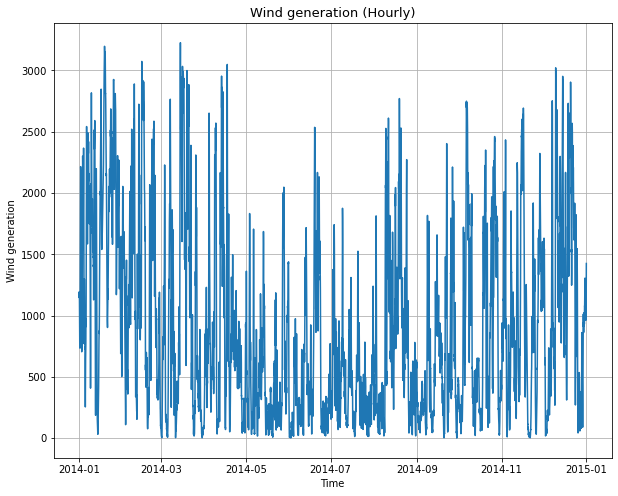

In [9]:
#plotting the timeseries for hourly sampling
plt.figure(figsize=(10,8))
plt.title("Wind generation (Hourly)", fontsize=13)
plt.plot(wind_gen["Wind Generation"])
plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.grid()
plt.show()

> From the above graph, the timeseries are sampled hourly and repeating patterns can be observed which indicate that the time series has an hourly seasonality component.

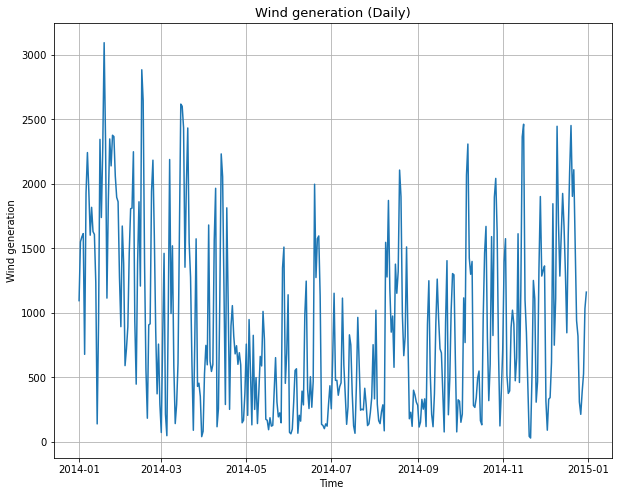

In [12]:
#plotting the timeseries for Daily sampling
daily = wind_gen.resample('D').mean()

plt.figure(figsize=(10,8))
plt.title("Wind generation (Daily)", fontsize=13)
plt.plot(daily)
plt.xlabel("Time ")
plt.ylabel("Wind generation")
plt.grid()
plt.show()

> From the above graph, the time series are sampled daily and there is weak daily seasonality because there are no consistent patterns over time.

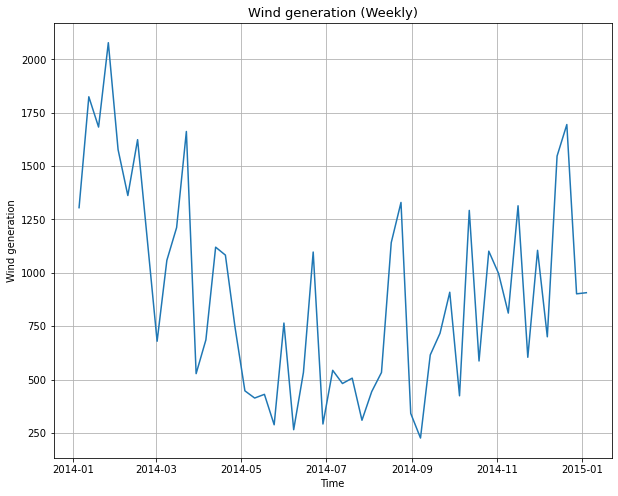

In [13]:
#plotting the timeseries for Weekly sampling
weekly = wind_gen.resample('W').mean()

plt.figure(figsize=(10,8))
plt.title("Wind generation (Weekly)", fontsize=13)
plt.plot(weekly)
plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.grid()
plt.show()

> From the above, the timeseries are sampled weekly and there are no consistently repeating patterns over time so there is very weak seasonality.

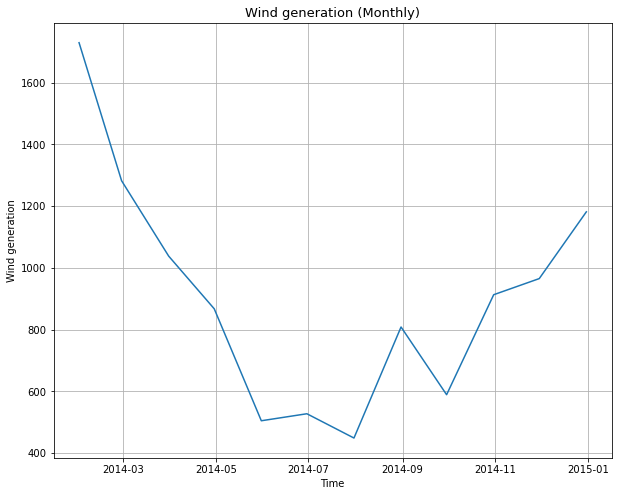

In [14]:
#plotting the timeseries for Monthly sampling
monthly  = wind_gen.resample('M').mean()

plt.figure(figsize=(10,8))
plt.title("Wind generation (Monthly)", fontsize=13)
plt.plot(monthly)
plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.grid()
plt.show()

> From the above graph, it can be observed that there is no monthly seasonality in the timeseries as there are no repeating patterns

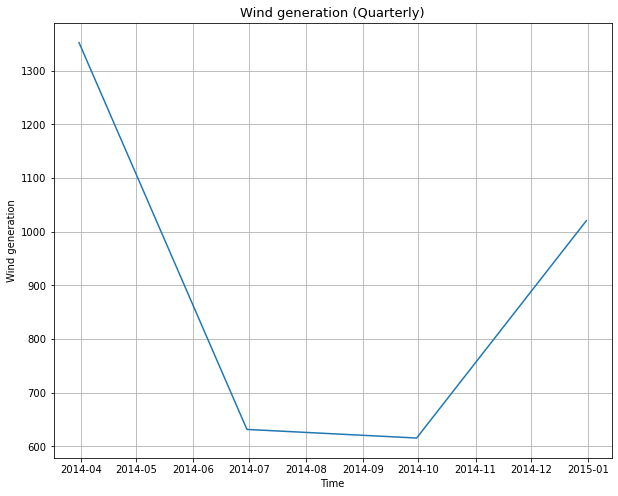

In [15]:
#plotting the timeseries for Quartely sampling
quarterly = wind_gen.resample('Q').mean()

plt.figure(figsize=(10,8))
plt.title("Wind generation (Quarterly)", fontsize=13)
plt.plot(quarterly)
plt.xlabel("Time")
plt.ylabel("Wind generation")
plt.grid()
plt.show()

> From the above, there are no repeating patterns in the time series hence there is no quarterly seasonality.

### Section 2

> In this section, we observe the change in wind power generation sampled for different time scales. In addition, we analyze the cumulative distribution function of the wind power generation and further compare it with a normal CDF at the standard deviation of the time series.

In [17]:
#percentage change in wind generation
max_gen = wind_gen["Wind Generation"].max()

wind_gen["Change"] = 100*wind_gen["Wind Generation"].diff()/max_gen
wind_gen

,Wind Generation,Change
Date,,
2014-01-01 00:00:00,1190.1,NaN
2014-01-01 01:00:00,1186.6,-0.108514
2014-01-01 02:00:00,1174.3,-0.381348
2014-01-01 03:00:00,1146.7,-0.855708
2014-01-01 04:00:00,1156.8,0.313139
...,...,...
2014-12-31 19:00:00,996.8,-0.936318
2014-12-31 20:00:00,1031.8,1.085137
2014-12-31 21:00:00,1218.0,5.772927


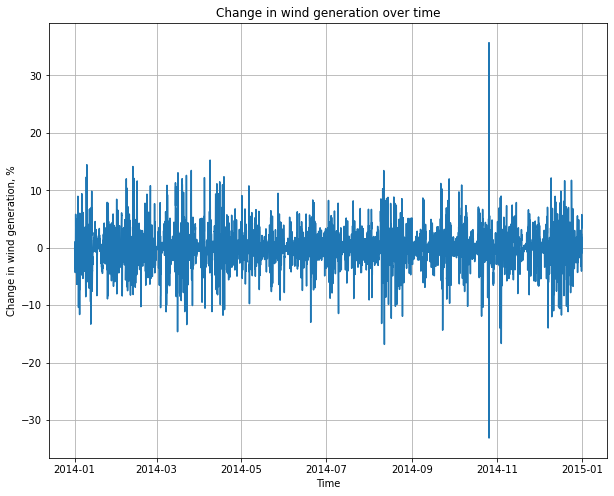

In [19]:
#plotting the change in wind generatiom
plt.figure(figsize=(10,8))
plt.title("Change in wind generation over time")
plt.plot(wind_gen["Change"])
plt.xlabel("Time")
plt.ylabel("Change in wind generation, %")
plt.grid()
plt.show()

> The above graph also shows evidence of a seasonality component because there are repeating patterns in the time series.

In [20]:
#negative and positive ramps
neg_ramps = abs(wind_gen[wind_gen["Change"]<0]["Change"])
pos_ramps = wind_gen[wind_gen["Change"]>0]["Change"]

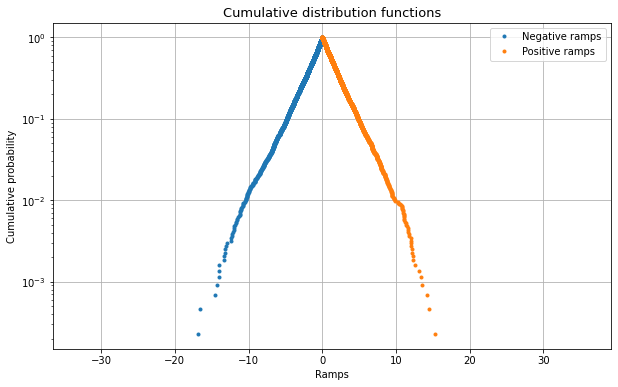

In [25]:
#cumulative distribution functions for both negative and positive ramps
ecdf_negative = ECDF(neg_ramps)
ecdf_positive = ECDF(pos_ramps)

#plotting the CDFs
plt.figure(figsize=(10,6))
plt.title("Cumulative distribution functions", fontsize=13)
plt.semilogy(-ecdf_negative.x, 1 - ecdf_negative.y,".", label="Negative ramps")
plt.semilogy(ecdf_positive.x, 1 - ecdf_positive.y, ".",label="Positive ramps")
plt.xlabel("Ramps")
plt.ylabel("Cumulative probability")
plt.legend()
plt.grid()
plt.show()

> The x-axis values correspond to the ramps and the y-axis values correspond to the logarithm of the probability of observing values greater than a given ramp value. 

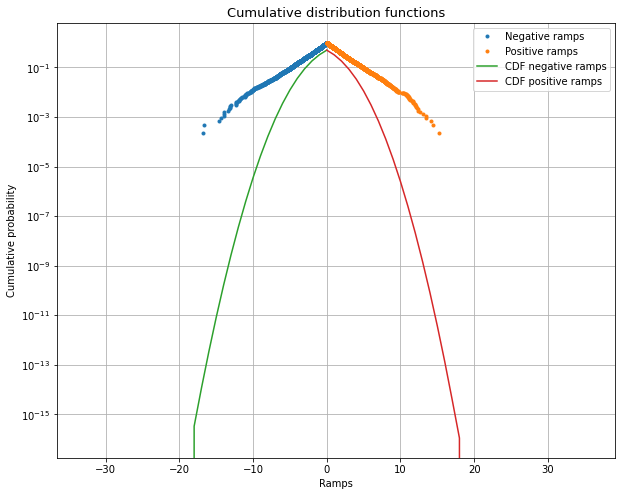

In [24]:
#standardizing the data
ramps = wind_gen["Change"][1:]
mean = ramps.mean()
std = ramps.std()
standardized_ramps = (ramps-mean)/std

x = np.arange(-0, 20, 1)

#normal CDF
negative_cdf = norm.cdf(x, 0, np.std(neg_ramps))
positive_cdf = norm.cdf(x, 0, np.std(pos_ramps))

#plotting the normal CDF
plt.figure(figsize=(10,8))
plt.title("Cumulative distribution functions", fontsize=13)
plt.semilogy(-ecdf_negative.x, 1 - ecdf_negative.y, ".", label="Negative ramps")
plt.semilogy(ecdf_positive.x, 1 - ecdf_positive.y, ".", label="Positive ramps")
plt.semilogy(-x, 1 - negative_cdf, label="CDF negative ramps")
plt.semilogy(x, 1 - positive_cdf, label="CDF positive ramps")
plt.xlabel("Ramps")
plt.ylabel("Cumulative probability")
plt.legend()
plt.grid()
plt.show()

> The above graph represents the normal cumulative distribution function with mean zero and standard deviation from the negative and positive ramps respectively. The distribution spread of the ramps can also be observed and the steepness of the tails suggests there are few large wind generation values.
From the above normal CDF, it can be deduced that a normal CDF is not necessarily a good model for wind power extremes as it fails to fit the tails of the distribution meaning that it doesn’t allow for a higher probability of extreme events.

### Section 3

> In the section, we observe the variability of the wind power generation over different scales by computing and comparing percentiles over the different time scales.

In [26]:
#computing variability over different timescales
for d in range(1,25):
    wind_gen[f"timescale_{d}"] = 100*-(wind_gen["Wind Generation"]).diff(periods=d)/max_gen
    
wind_gen

,Wind Generation,Change,timescale_1,timescale_2,timescale_3,timescale_4,timescale_5,timescale_6,timescale_7,timescale_8,...,timescale_15,timescale_16,timescale_17,timescale_18,timescale_19,timescale_20,timescale_21,timescale_22,timescale_23,timescale_24
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,1190.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,1186.6,-0.108514,0.108514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:00:00,1174.3,-0.381348,0.381348,0.489862,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:00:00,1146.7,-0.855708,0.855708,1.237056,1.345570,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 04:00:00,1156.8,0.313139,-0.313139,0.542568,0.923916,1.032430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,996.8,-0.936318,0.936318,0.778198,-1.075836,1.540894,5.611707,4.985428,2.560923,1.280461,...,7.236312,7.800583,7.595957,7.267316,7.614559,9.567806,9.174056,7.366528,4.349848,4.005705
2014-12-31 20:00:00,1031.8,1.085137,-1.085137,-0.148819,-0.306939,-2.160972,0.455757,4.526570,3.900291,1.475786,...,5.934148,6.151175,6.715446,6.510820,6.182179,6.529423,8.482669,8.088919,6.281391,3.264711
2014-12-31 21:00:00,1218.0,5.772927,-5.772927,-6.858064,-5.921746,-6.079866,-7.933900,-5.317170,-1.246357,-1.872636,...,0.778198,0.161220,0.378248,0.942519,0.737893,0.409252,0.756495,2.709741,2.315992,0.508464


In [28]:
#selecting the time scales columns
timescales = wind_gen.iloc[:, 2:]
timescales

,timescale_1,timescale_2,timescale_3,timescale_4,timescale_5,timescale_6,timescale_7,timescale_8,timescale_9,timescale_10,...,timescale_15,timescale_16,timescale_17,timescale_18,timescale_19,timescale_20,timescale_21,timescale_22,timescale_23,timescale_24
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 01:00:00,0.108514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:00:00,0.381348,0.489862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:00:00,0.855708,1.237056,1.345570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 04:00:00,-0.313139,0.542568,0.923916,1.032430,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,0.936318,0.778198,-1.075836,1.540894,5.611707,4.985428,2.560923,1.280461,2.846159,6.120171,...,7.236312,7.800583,7.595957,7.267316,7.614559,9.567806,9.174056,7.366528,4.349848,4.005705
2014-12-31 20:00:00,-1.085137,-0.148819,-0.306939,-2.160972,0.455757,4.526570,3.900291,1.475786,0.195325,1.761022,...,5.934148,6.151175,6.715446,6.510820,6.182179,6.529423,8.482669,8.088919,6.281391,3.264711
2014-12-31 21:00:00,-5.772927,-6.858064,-5.921746,-6.079866,-7.933900,-5.317170,-1.246357,-1.872636,-4.297141,-5.577603,...,0.778198,0.161220,0.378248,0.942519,0.737893,0.409252,0.756495,2.709741,2.315992,0.508464


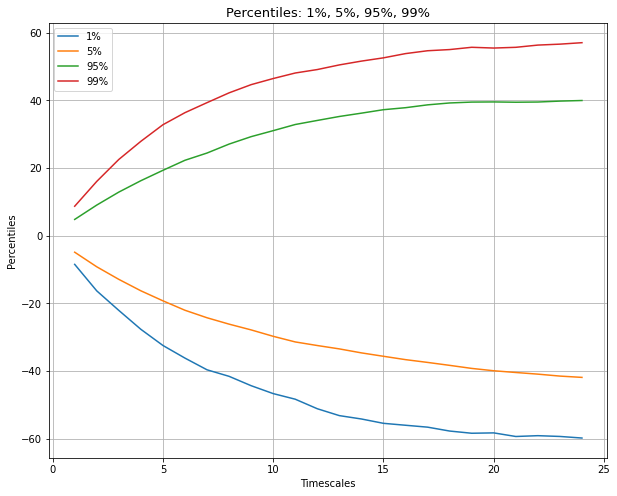

In [30]:
#computing percentiles
perc_1 = [timescales[col].quantile(0.01) for col in timescales.columns]
perc_5 = [timescales[col].quantile(0.05) for col in timescales.columns]
perc_95 = [timescales[col].quantile(0.95) for col in timescales.columns]
perc_99 = [timescales[col].quantile(0.99) for col in timescales.columns]

#plotting the percentiles
x = np.arange(1,25)
plt.figure(figsize=(10,8))
plt.title("Percentiles: 1%, 5%, 95%, 99%", fontsize=13)
plt.plot(x, perc_1, label="1%")
plt.plot(x, perc_5, label="5%")
plt.plot(x, perc_95, label="95%")
plt.plot(x, perc_99, label="99%")
plt.xlabel("Timescales")
plt.ylabel("Percentiles")
plt.grid()
plt.legend()
plt.show()

> From the above graph, the 1st and 5th percentiles decrease as the wind generation is sampled at higher time scales (as d increases), in contrast, the 95th and 99th percentiles increase as time scales increase (as d increases). These percentiles represent the wind generations values below which the percentage of the data fall under.

### Section 4

> In this section, we analyze the autocorrelation of wind power generationa and that of change in wind power generation

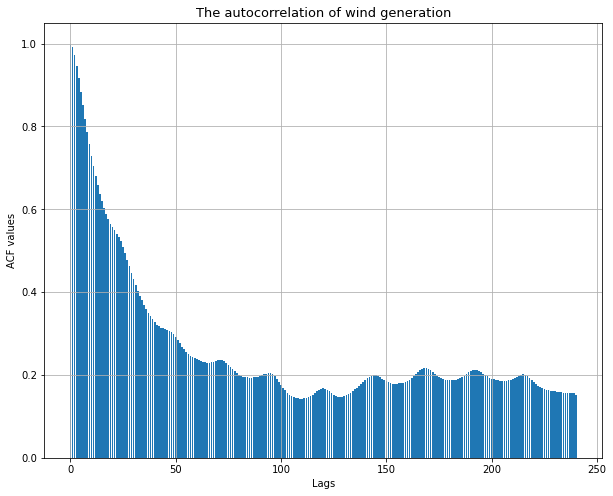

In [31]:
#plotting the autocorrelation of wind generation
acf_values = acf(wind_gen["Wind Generation"], nlags=240, missing="drop")

plt.figure(figsize=(10,8))
plt.title("The autocorrelation of wind generation", fontsize=13)
plt.bar(range(len(acf_values)), acf_values)
plt.xlabel("Lags")
plt.ylabel("ACF values")
plt.grid()
plt.show()

> A high degree of autocorrelation can be observed for multiple subsequent lags. Overall, it decreases over time. In addition, there is a component of seasonality.

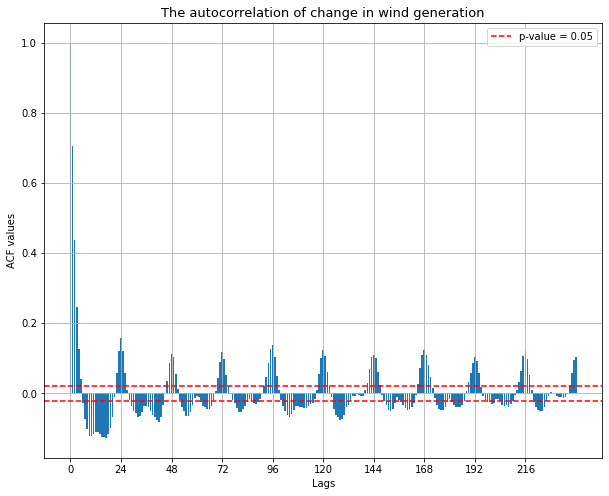

In [33]:
#plotting the autocorrelation of change in wind generation
acf_change = acf(wind_gen["Change"], nlags=240, missing="drop")

line1 = 1.96/((len(wind_gen["Change"]))**0.5)
line2 = -1.96/((len(wind_gen["Change"]))**0.5)

plt.figure(figsize=(10,8))
plt.title("The autocorrelation of change in wind generation", fontsize=13)
plt.bar(range(len(acf_change)), acf_change)
plt.axhline(line1, color="red", linestyle="--", label="p-value = 0.05")
plt.axhline(line2, color="red", linestyle="--")
plt.xticks(np.arange(0,240,24))
plt.xlabel("Lags")
plt.ylabel("ACF values")
plt.grid()
plt.legend()
plt.show()

> Horizontal lines are plotted to represent the statistical significance of p<0.05 using 95% confidence intervals (±1.96/√n).

>From the above ACF, there is evidence of diurnal seasonality because of the daily repeating patterns in the lags. The horizontal lines show autocorrelation values corresponding to statistically significant p-value=0.05. The lags with values between the two horizontal lines are not statistically significant. The ones above the first line and the ones below the second line are statistically significant.
> Furthermore, it might be better to model change in wind generation than wind generation because it shows the existing seasonal component in the time series, and statistically significant lags can be easily detected.

### Section 5

> In this section, we perfrom a variance ratio test with a null hypothesis of the time series being a random walk. We also compute simple moving averages over different time scales form [1-24]. In this case the persistence benchmark will coresspond to a simple moving average with a rolling window of k=1

> we also perfrom forecast horizons where X(t) = X(t-n), with n in the range of [1,24].

>For both models, we compute the Mean Absolute Errors

In [34]:
#performing the variance ratio test
timeseries = wind_gen["Wind Generation"].dropna()
vratio = VarianceRatio(timeseries)

In [35]:
#test statistic and p-value
print(f"The test statistic: {vratio.stat}")
print(f"The p-value: {vratio.pvalue}")

The test statistic: 27.539123083432386
The p-value: 0.0


> The above p-value is less than the significance threshold of p=0.05, which means that the test statistic is statistically significant. Therefore, the null hypothesis that the time series is a random walk is rejected.
> The variance ratio compares the variance of a 1-period wind generation to that of a multi-period wind generation. A high variance ratio suggests that there is autocorrelation in the time series, and past values can influence present values. Also, a variance ratio greater than 1, means that there is evidence of mean aversion (the wind power generation tends to go further away from the long-term mean) in the time series.

In [36]:
#computing the optimal simple moving average
sma_mae = []
for i in range(1,25):
    sma = timeseries.rolling(i).mean()
    nans = sma.isnull().sum()
    sma.dropna(inplace=True)
    mae = mean_absolute_error(timeseries[nans:], sma)
    sma_mae.append(mae)
    if i==1:
        min_mae = mae
        min_n = i
    elif mae < min_mae:
        min_mae = mae
        min_n = i
        
print(f"The optimal SMA is {min_n} with minimum MAE = {min_mae}")

The optimal SMA is 1 with minimum MAE = 0.0


In [37]:
#the MAE for SMA
sma_mae

[0.0,
 33.25041100582258,
 62.6059145923727,
 89.01583304784742,
 113.01821608040201,
 134.92258138206742,
 155.08494239368122,
 173.7817134125443,
 190.97323532398946,
 206.73555136555822,
 221.09293194805198,
 234.3088876824018,
 246.7063742042137,
 258.2142865308922,
 268.8431572528394,
 278.6731811034877,
 287.82442750659277,
 296.3948790778654,
 304.25108971811824,
 311.38325820844295,
 317.89432276343035,
 323.81468963580187,
 329.28753271567473,
 334.5086313952158]

In [38]:
#comparing persistence benchmark and forecast horizons
mae_values = []
for i in range(1,25):
    predicted_x = timeseries.shift(-i)
    predicted_x.dropna(inplace=True)
    mae = mean_absolute_error(timeseries[:-i], predicted_x)
    mae_values.append(mae)
    if i==1:
        min_mae = mae
        min_n = i
    elif mae < min_mae:
        min_mae = mae
        min_n = i
        
print(f"The minimum MAE = {min_mae}")
print(f"The minimum n = {min_n}")

The minimum MAE = 66.50082201164516
The minimum n = 1


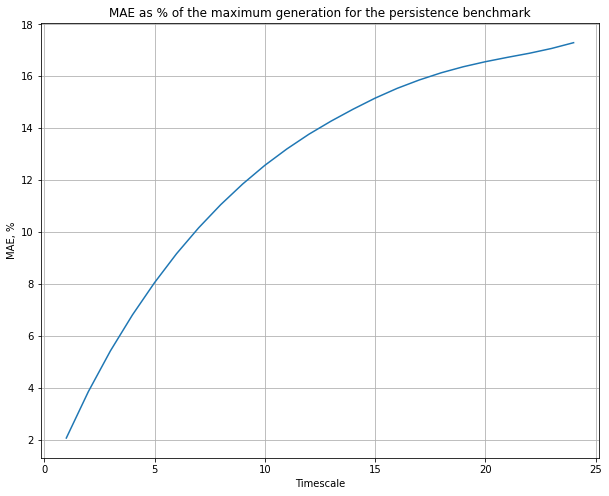

In [40]:
#plotting MAE
mae_percent = [100*(x/max_gen) for x in mae_values]

plt.figure(figsize=(10,8))
plt.title("MAE as % of the maximum generation for the persistence benchmark")
plt.plot(np.arange(1,25), mae_percent)
plt.xlabel("Timescale")
plt.ylabel("MAE, %")
plt.grid()
plt.show()

> From the above graph, it can be observed that as the time scale used in the forecast horizon increase, the mean absolute errors increase as well.

### Section 6

> In this section we fit an ARIMA model to the time series. We loop through different values of p (the number of autoregressive terms that influence the current values), q (the window size for moving averages) in the range of [1,4] to find the optimal parameters. d is set to 1 and sepcifies the number of times the time series must be differenced to remove seasonality and trend. The performance of the models is evaluated based on the Bayesian and Akaike Information Criteria.

In [41]:
#fitting ARIMA model with different parameters
for p in range(1,5):
    for q in range(1,5):
        arima_model = ARIMA(wind_gen["Wind Generation"], order=(p,1,q)).fit()
        bic = arima_model.bic
        aic = arima_model.aic
        
        if p==1 and q==1: #first iteration
            min_aic = aic
            min_bic = bic
            optimal_p = p
            optimal_q = q
            
        if bic < min_bic and aic < min_aic: #minimum BIC and AIC
            min_bic = bic
            min_aic = aic
            optimal_p = p
            optimal_q = q

In [42]:
#the optimal parameters
print(f"The minimum BIC: {min_bic} and minimum AIC: {min_aic} correspond to p = {optimal_p} and q = {optimal_q}")

The minimum BIC: 98817.04283301445 and minimum AIC: 98781.65364790363 correspond to p = 3 and q = 1
